In [1]:
# Workspace problem with several narrow gaps

import torch
import torch.nn as nn
from torch.nn.modules import loss
import torch.optim as optim

import numpy as np
import matplotlib.pyplot as plt
import cv2

cuda = False
DEVICE = torch.device("cuda" if cuda else "cpu")

In [2]:
# neural network parameters
mb_size = 256 # mini batch dim
h_Q_dim = 512*2 # encoder dim
h_P_dim = 512*2 # decoder dim

lr = 1e-4 # learning rate

nDrawnSamples = 4 # number of dependent samples to draw during smapling
dim = 4 # (x, y, xdot, ydot)
dataElements = nDrawnSamples * dim + 2 * dim # sample (4D), init (4D), goal (4D)

z_dim = 2 # latent dim
X_dim = dim*nDrawnSamples # samples dim
y_dim = dim # reconstruction of the original point (unsused?)
c_dim = dataElements - dim # dimension of conditioning variable

In [4]:
# read in data from .txt file, re-arrange to allow drawing multiple depedent samples

filename = '/home/oscar_palfelt/MSc_thesis/EECS_Degree_Project/learn_states/motion_planning/data/mapA_data'
rawdata = np.genfromtxt(filename, delimiter=',', dtype='d')
_, pathsIdx = np.unique(rawdata[:,4:], axis=0, return_index=True)
pathsIdx.sort()

pathsLenghts = pathsIdx[1:] - pathsIdx[:-1]
validLengthsIdx = np.argwhere(pathsLenghts >= nDrawnSamples)
validPlansIdx = pathsIdx[validLengthsIdx]

data = np.zeros(shape=(1, dim*nDrawnSamples + dim*2))

for c, i in enumerate(validPlansIdx.reshape(-1)):
    rndSample = np.random.choice(np.arange(pathsLenghts[c]), size=(np.floor(pathsLenghts[c] / nDrawnSamples).astype(int), nDrawnSamples), replace=False)
    rndSample.sort(axis=1)

    for sample in rndSample:
        data = np.vstack((data,np.append(rawdata[i + sample, :4].reshape(1, dim*nDrawnSamples), rawdata[i, 4:].reshape(1, dim*2), axis=1))) 

numEntries = data.shape[0]
print(numEntries)

10346


In [5]:
# split the inputs and conditions into test train (to be processed in the next step into an occupancy grid representation)
ratioTestTrain = 0.8;
numTrain = int(numEntries*ratioTestTrain)

X_train = data[0:numTrain,0:dim*nDrawnSamples] # samples state: x, y, xdot, ydot

X_test = data[numTrain:numEntries,0:dim*nDrawnSamples]
numTest = X_test.shape[0]

In [7]:
# generate conditioning variable
filename = '/home/oscar_palfelt/MSc_thesis/EECS_Degree_Project/learn_states/motion_planning/maps/mapA.png'
mapImg = cv2.imread(filename, 0)
occGrid = np.clip(mapImg, 0, 1)

assert occGrid.shape[0] == occGrid.shape[1]
gridSize = occGrid.shape[0]

#conditionsOcc = np.tile(occGrid.reshape(1, gridSize ** 2), reps=(numEntries,1))
#cs = np.concatenate((data[0:numEntries,dim:dataElements], conditionsOcc), axis=1) # init (4D), goal (4D), occ(30x30)
cs = data[0:numEntries,dim*nDrawnSamples:dataElements]
c_dim = cs.shape[1]
c_train = cs[0:numTrain,:] 
c_test = cs[numTrain:numEntries,:]

In [9]:
# define pytorch networks
# based on https://github.com/Jackson-Kang/Pytorch-VAE-tutorial/blob/master/.ipynb_checkpoints/01_Variational_AutoEncoder-checkpoint.ipynb

class Encoder(nn.Module):
    
    def __init__(self, input_dim=X_dim+c_dim, hidden_dim=h_Q_dim, latent_dim=z_dim):
        super(Encoder, self).__init__()

        self.network = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU()
        )

        self.z_mu = nn.Linear(hidden_dim, latent_dim)
        self.z_logvar = nn.Linear(hidden_dim, latent_dim)
        
    def forward(self, x):

        seq = self.network(x)

        return self.z_mu(seq), self.z_logvar(seq)


class Decoder(nn.Module):
    def __init__(self, latent_dim=z_dim+c_dim, hidden_dim=h_P_dim, output_dim=X_dim):
        super(Decoder, self).__init__()

        self.network = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim)
        )
        
    def forward(self, x):
        
        return self.network(x)


class NeuralNetwork(nn.Module):
    def __init__(self, Encoder, Decoder):
        super(NeuralNetwork, self).__init__()
        self.Encoder = Encoder
        self.Decoder = Decoder
    
    def reparameterization(self, mean, logvar):
        epsilon = torch.randn_like(mean).to(DEVICE)        # sampling epsilon        
        z = mean + torch.exp(0.5 * logvar) * epsilon       # reparameterization trick
        return z

    def forward(self, x, c, encode=True):
        if encode:
            z_mu, z_logvar = self.Encoder(torch.cat((x, c), dim=1))
            z = self.reparameterization(z_mu, z_logvar)

            y = self.Decoder(torch.cat((z, c), dim=1))
            
            return y, z_mu, z_logvar
        else:
            z = x
            y = self.Decoder(torch.cat((z, c), dim=1))    

            return y


encoder = Encoder()
decoder = Decoder()
network = NeuralNetwork(Encoder=encoder, Decoder=decoder).to(DEVICE)

weight = torch.tensor([1, 1, 0.5, 0.5], requires_grad=False, dtype=torch.float32, device=DEVICE)

def loss_function(x, y, mean, logvar):
    recon_loss = (weight.repeat(1, nDrawnSamples) * (x - y) ** 2).mean()
    kl_loss    = 10**-4 * 2 * torch.sum(torch.exp(logvar) + mean.pow(2) - 1. - logvar, dim=1)

    return torch.mean(kl_loss + recon_loss)

optimizer = optim.Adam(network.parameters(), lr=lr)


In [14]:
# Training
for it in range(100001):
    # randomly generate batches
    batch_elements = [np.random.randint(0,numTrain-1) for n in range(0,mb_size)]

    X_mb = torch.tensor(X_train[batch_elements,:], requires_grad=True, dtype=torch.float32, device=DEVICE)
    c_mb = torch.tensor(c_train[batch_elements,:], requires_grad=True, dtype=torch.float32, device=DEVICE)

    optimizer.zero_grad()

    y, z_mu, z_logvar = network(X_mb, c_mb)
    
    loss = loss_function(X_mb, y, z_mu, z_logvar)
    loss.backward()
    optimizer.step()

    if it % 1000 == 0:
        print('Iter: {}'.format(it))
        print('Loss: {:.4}'. format(loss))
        print()

Iter: 0
Loss: 0.3121



KeyboardInterrupt: 

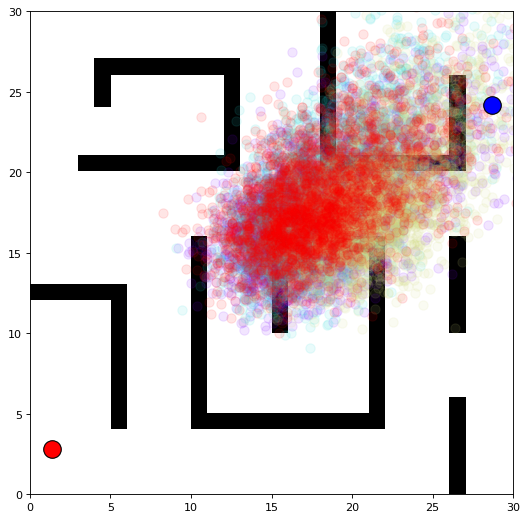

In [15]:
# plot the latent space

num_viz = 3000 # number of samples to draw in latent space
vizIdx = np.random.randint(0,numTest-1); # chose a random test scenario
c_sample_seed = c_test[vizIdx,:]
c_sample = torch.from_numpy(np.repeat([c_sample_seed],num_viz,axis=0)).float().to(DEVICE)

y_viz = network(torch.randn(num_viz, z_dim).to(DEVICE), c_sample, encode=False).cpu().detach().numpy() # y_viz is sample in state space, zviz in latent space (3D)

fig1 = plt.figure(figsize=(8,8), dpi=80)
color = plt.cm.rainbow(np.linspace(0, 1, nDrawnSamples))
for i in range(nDrawnSamples):
    plt.scatter(y_viz[:,0 + i*dim] * gridSize, y_viz[:,1 + i*dim] * gridSize, color=color[i], s=70, alpha=0.1)
plt.scatter(c_test[vizIdx, 0] * gridSize, c_test[vizIdx, 1] * gridSize, color="red", s=250, edgecolors='black') # init
plt.scatter(c_test[vizIdx, 4] * gridSize, c_test[vizIdx, 5] * gridSize, color="blue", s=250, edgecolors='black') # goal
plt.imshow(mapImg, extent=[0, gridSize, 0, gridSize], cmap='gray')

plt.show()